# Exercício de Programação: PCA

<font color="red">**Prazo de submissão: 23:59 do dia 30/05/2025** </font>

2025.1 Álgebra Linear Computacional - DCC - UFMG

Erickson

Instruções:
* Antes de submeter suas soluções, certifique-se de que tudo roda como esperado. Primeiro, **reinicie o kernel** no menu, selecione Kernel->Restart e então execute **todas as células** (no menu, Cell->Run All)
* Apenas o arquivo .ipynb deve ser submetido. Ele não deve ser compactado.
* Não deixe de preencher seu nome e número de matrícula na célula a seguir

**Nome dos alunos e matrícula:**  
INSIRA Nome1: Gabriel Guimarães dos Santos Ricardo, Matricula1: 2024024062  
INSIRA Nome2: João Pedro Moreira Smolinski, Matricula2: 2024023996  

Nesta lista, a parte inicial é apenas para sua orientação. Ela mostra um sistema de classificação de faces em fotos e você não precisa entregar nada acerca desta parte inicial.  O que você precisa entregar ́é um exercício quase idêntico para classificar dígitos manuscritos usando a mesma técnica desta parte inicial. Veja a seção **Exercício** no final deste documento.

# Tutorial de reconhecimento de faces usando PCA - Eigenfaces

O arquivo ```DadosYaleFaces.zip```, na pasta ```data```, contem diretórios com arquivos de fotos de 15 indivíduos, um diretório para cada indivíduo. Dentro deles, temos 11 fotos de cada indivíduo. As fotos variam de acordo com aspectos tais como iluminação, expressão (sorrindo, sério, triste), pela presença de óculos ou não. A Figura 1 exibe uma amostra dessas fotos. Cada linha de fotos corresponde a um indivíduo.  As imagens são normalizadas para alinhar os olhos e bocas. Eles aparecem mais ou menos no mesmo local na imagem. 

<div style="text-align:center"><img src="images/SampleFaces.png" /><br>
    <em>Figura 1: Amostra de 5 fotos de 4 indivíduos.</em></div>


Vamos fazer uma análise das fotos via componentes principais com o objetivo de reconhecer estes rostos. Imagine que você tenha uma base de dados com várias fotos de um conjunto de indivíduos. Você vai especificar um sistema de vigilância para uma companhia e apenas os 15 indivíduos destas fotos podem entrar num certo local. A checagem é feita automaticamente com uma nova foto tirada no momento da tentativa de entrada. Vamos usar o PCA para criar um sistema para classificar esta nova foto a uma das 15 classes representadas pelos diferentes indivíduos. Assim, o problema é: Chega uma nova foto. Queremos encontrar o rosto mais parecido com a nova foto no banco de dados. Se o rosto mais parecido não estiver próximo o suficiente da nova foto, a entrada não é permitida.

O  método das _autofaces_ foi proposto por Turk and Pentland (1991a, 1991b). Ele é principalmenteum método de redução de dimensionalidade, podendo representar muitos indivíduos com um conjunto relativamente pequeno de dados. A idéia é representar a foto de um rosto como uma soma de um rosto médio mais uma combinação linear de um pequeno número de pseudo-fotos, que são as _autofaces_.  Estas _autofaces_ são fotos embaçadas que capturam aspectos importantes da composição de uma face.

Podemos imaginar cada foto sendo aproximadamente obtida como representado na Figura 2.  As fotos à  esquerda são aproximadamente iguais a uma mesma foto média (a primeira do lado direito) mais quatro autofaces, cada uma delas multiplicada por um peso $w_{ij}$ que é específico do indivíduo. Diferentes indivíduos vão variar apenas nos 4 pesos $w_{ij}$ que cada autoface recebe. As autofaces são fixas e as mesmas para todos os indivíduos considerados, bem como a face média, que também é a mesma para todos

<div style="text-align:center"><img src="images/IdeiaAutoFaces.png" /><br>
    <em>Figura 2: Uma foto (a esquerda) é aproximandamente a soma de uma foto média mais quatro autofaces multiplicadas por pesos <img src="http://latex.codecogs.com/svg.latex?w_{ij}" border="0"/>
 específicos do indivíduo. Diferentes indivíduos vão variar apenas nos 4 pesos <img src="http://latex.codecogs.com/svg.latex?w_{ij}" border="0"/>
 que cada autoface recebe</em></div>

Primeiramente, vamos ler as fotos em Python. Vou usar a biblioteca Pillow que fornece algumas funcionalidades para processamento de imagens no Python. Informações em https://pillow.readthedocs.io/en/stable/. Essa biblioteca é baseada na bilbioteca Pil (Python Image Library). O script para instalar segue abaixo:

In [1]:
import sys
!{sys.executable} -m pip install --user Pillow scikit-learn

<font color="red">**Atenção caso o script não funcione basta executar o comando a seguir** </font>

```pip install Pillow scikit-learn```

pode ser necessário possuir permisões de administrador. 

A função ```open``` le imagens em um arquivo. Vamos carregar a imagem no arquivo **Faces3/s5.jpg** e visualizá-la.

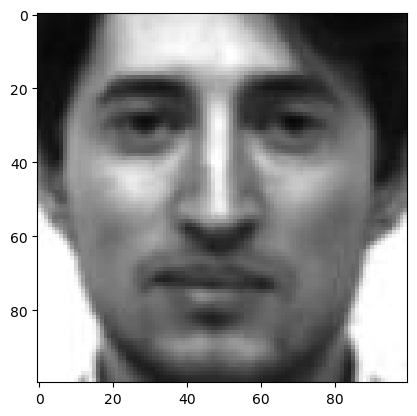

In [4]:
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

image = Image.open('./DadosYaleFaces/Faces3/s5.jpg')
plt.imshow(image)

```image``` é um objeto do tipo Image da biblioteca Pillow. Com 100 $\times$ 100 pixels com 3 canais de cor, o usual RGB.

Podemos transformar o objeto ```image``` em um ```numpy.array``` e vice-versa. Vejam abaixo

Esse é o tamanho da imagem: Altura: 100  Largura: 100 Canais de cor: 3


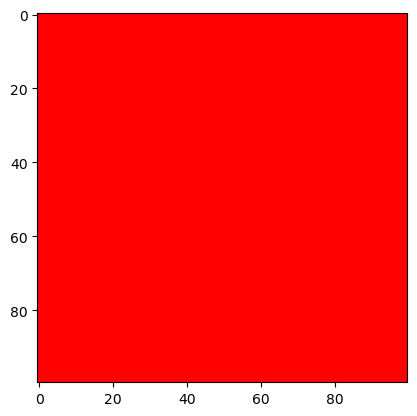

In [5]:
import numpy as np

#image to numpy.array
image = np.asarray(image)
print('Esse é o tamanho da imagem: Altura:',image.shape[0],' Largura:',image.shape[1],'Canais de cor:',image.shape[2])
#numpy.array to image
a = np.ones((100,100,3))
a[:,:,0] = a[:,:,0] * 255
i = Image.fromarray(np.uint8(a))
plt.imshow(i)

Agora iremos ler todas as fotos dos indivíduos. Existem 15 indivíduos separados em 15 diretório. E dentro de cada um desses diretórios possuem 11 imagens em formato ```jpg``` e ```bmp```. Cada uma dessas fotos correspondem a diferentes poses de um mesmo indivíduo.Vamos ver como fazer a leitura das fotos e armazenamento na lista **fotos**

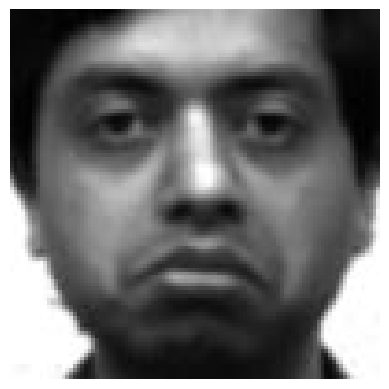

In [10]:
import os

fotos = []
for i in range(1,16):
    fotos_individuo = []
    for j in range(1,12):
        fotos_individuo.append(Image.open('./DadosYaleFaces/Faces'+str(i)+'/s'+str(j)+'.jpg'))
    fotos.append(fotos_individuo)

##Podemos exibir a imagem 7 do individuo 9, com o comando
plt.axis('off')
plt.imshow(fotos[9][7])

Podemos observar algumas imagens aleatórias da seguinte maneira

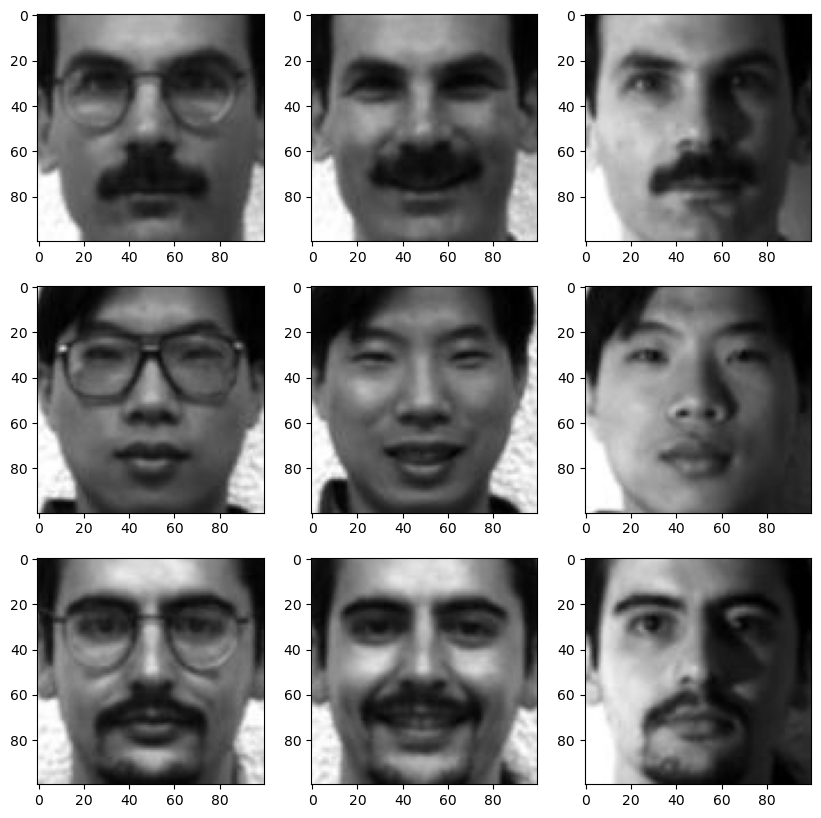

In [11]:
plt.figure(figsize=(10, 10))

plt.subplot(331)
plt.imshow(fotos[1][1])
plt.subplot(332)
plt.imshow(fotos[1][2])
plt.subplot(333)
plt.imshow(fotos[1][3])

plt.subplot(334)
plt.imshow(fotos[3][1])
plt.subplot(335)
plt.imshow(fotos[3][2])
plt.subplot(336)
plt.imshow(fotos[3][3])

plt.subplot(337)
plt.imshow(fotos[8][1])
plt.subplot(338)
plt.imshow(fotos[8][2])
plt.subplot(339)
plt.imshow(fotos[8][3])

plt.show()

Para a análise de componentes principais, vamos converter as fotos em matrizes e colocá-las numa lista ```fotosmat```

In [12]:
fotosmat = []
for i in range(15):
    fotosmat_individuo = []
    for j in range(11):
        fotosmat_individuo.append(np.asarray(fotos[i][j]))
    fotosmat.append(fotosmat_individuo)
fotosmat = np.asarray(fotosmat)

Todos os canais de cor das imagens são iguais, vocês podem confirmar isso com o código abaixo.

In [15]:
print(fotosmat[0][0][:,:,1] == fotosmat[0][0][:,:,2])
fotosmat.shape

[[ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 ...
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]]


(15, 11, 100, 100, 3)

Agora iremos empilhar as colunas de cada uma das matrizes para montar uma matriz nova. Para isso iremos utilizar a função ```reshape``` passando o parâmetro ```order``` para utilizarmos a conveção adotada pela linguaguem de programação Fortran. Mais informações [https://docs.scipy.org/doc/numpy/reference/generated/numpy.reshape.html](https://docs.scipy.org/doc/numpy/reference/generated/numpy.reshape.html) 

Logo como todos os canais de cor são iguais iremos utilizar apenas 1 deles para realizar os cálculos.

In [14]:
mat_pixels = []
for i in range(15):
    for j in range(11):
        mat_pixels.append(fotosmat[i][j][:,:,0].reshape((-1,1),order='F'))
mat_pixels = np.asarray(mat_pixels).T[0]
mat_pixels.shape

(10000, 165)

In [16]:
import random

random.seed(42)
idx = random.randint(0,11)
print('Retiraremos a imagem de número ',idx,' de cada indivíduo.')
#Agora iremos montar a matriz de teste para o nosso método.
idxs = [idx+(i*11) for i in range(15)]
mat_teste = mat_pixels[:,idxs]
mat_pixels = mat_pixels[:,[i for i in range(165) if i not in idxs]]

Retiraremos a imagem de número  10  de cada indivíduo.


Precisamos centrar todas as fotos do conjunto de treinamento subtraindo de cada foto a foto média de todo o conjunto de fotos. Esta foto média é simplesmente a $fotoÂ'Â'$ obtida tirando a média aritmética sobre o conjunto de fotos em cada pixel. Isto é, para um pixel localizado numa certa posição, tiramos a média de todos os valores observados naquela posição nas diferentes fotos do conjunto de treinamento.

In [ ]:
mat_media = np.mean(mat_pixels,axis=1)
mat_centrada = (mat_pixels.T - mat_media.T).T

(10000,)

Vamos visualizar como é a nossa imagem média.

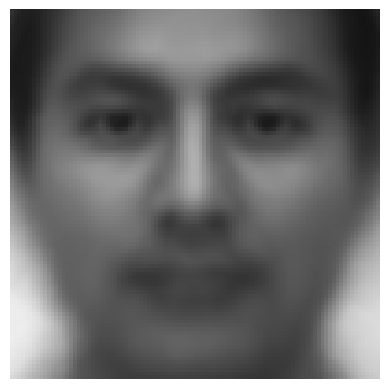

In [20]:
image = Image.fromarray(mat_media.reshape((100,100)).T)
plt.axis('off')
plt.imshow(image, cmap='gray')

Iremos utilizar o PCA para achar as principais componentes do nosso conjunto de dados. Iremos buscar pela quantidade de componentes que conseguem representar $90\%$ dos dados.

In [21]:
from sklearn.decomposition import PCA
pca = PCA(0.9)
pca.fit(mat_centrada.T)

#Quantas componentes não necessárias para representar os dados
print(pca.components_.shape)
#Podemos observar a contribuição de cada uma das componentes na representatividade dos dados
print(pca.explained_variance_ratio_ )
#Somando esses valores obtemos a nossa porcetagem.
print(np.sum(pca.explained_variance_ratio_ ))

print('utilizando os 10 primeiros componentes',np.sum(pca.explained_variance_ratio_[:10]))
print('utilizando os proximos 10 componentes',np.sum(pca.explained_variance_ratio_[:20]))

(26, 10000)
[0.20399713 0.18150999 0.13116882 0.0701215  0.04806165 0.03642303
 0.03046697 0.02647779 0.02222528 0.01778654 0.01550954 0.01422176
 0.01249448 0.01137386 0.00956269 0.00905978 0.00809801 0.00779198
 0.00743616 0.00685096 0.00587818 0.00583692 0.00518994 0.00507618
 0.00456907 0.00429453]
0.9014827462462525
utilizando os 10 primeiros componentes 0.7682386962723542
utilizando os proximos 10 componentes 0.8706379262687759


Veja a variância explicada por cada um dos componentes. Os 10 primeiros PCs explicam $76\%$ da variação total.  Acrescentar mais 10, ficando com 20 PCs, leva a $86\%$. Vamos realizar observar melhor como a variação acrescentada por cada componente vai evoluindo com mais componentes.

Text(0.5, 0, 'Qtd Principais Componentes')

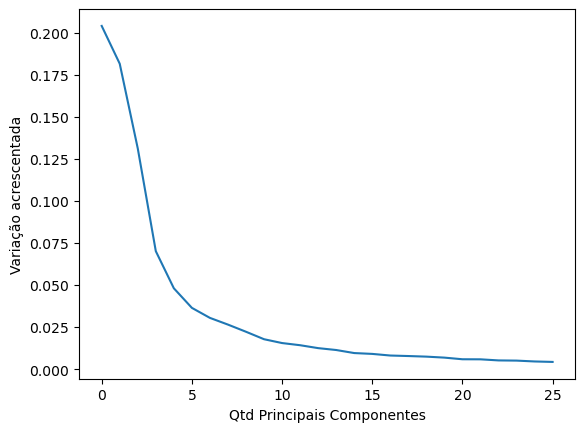

In [22]:
plt.plot(pca.explained_variance_ratio_)
plt.ylabel('Variação acrescentada')
plt.xlabel('Qtd Principais Componentes')

In [23]:
autovalores = pca.explained_variance_
autovetores = pca.components_

Vamos criar agora as autofaces. Vamos desempilhar os autovetores quebrando a coluna de cada um delesem 100 colunas de tamanho 100 cada uma. Com isto, cada autovetor dá origem a uma $imagemÂ'Â'$ ́com a mesma quantidade de pixels que as fotos originais. Vamos chamar estas pseudo-fotos de **autofaces**. Iremos utilizar apenas os 20 primeiros autovetores para isso.

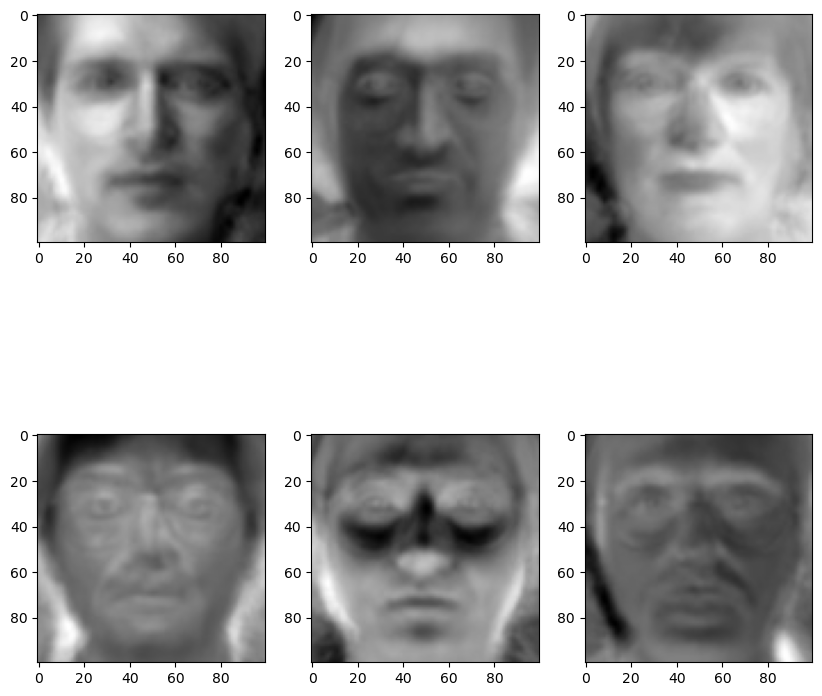

In [24]:
auto_faces = []
for i in range(20):
    auto_faces.append(pca.components_[i].reshape((100,100)))
auto_faces = np.asarray(auto_faces)
#Vamos ver algumas fotos
plt.figure(figsize=(10, 10))

plt.subplot(231)
plt.imshow(auto_faces[0].T, cmap='gray')
plt.subplot(232)
plt.imshow(auto_faces[1].T, cmap='gray')
plt.subplot(233)
plt.imshow(auto_faces[2].T, cmap='gray')

plt.subplot(234)
plt.imshow(auto_faces[3].T, cmap='gray')
plt.subplot(235)
plt.imshow(auto_faces[4].T, cmap='gray')
plt.subplot(236)
plt.imshow(auto_faces[5].T, cmap='gray')

plt.show()

Vamos visualizar uma face em **mat_teste** sua aproximação usando as $k$ primeiras autofaces. Para isto precisamos escrever uma foto como aproximadamente uma soma da foto média mais uma combinação linear das primeiras $k$ autofaces (todos como vetores). Em seguida, desempilhamos os vetores e mostramos as faces. Por exemplo, usando a face na coluna 5 de **mat_teste**.  Vamos obter os coeficientes $b_k$da combinação linear $mboxfoto≈fotomedia +b_1v_1+b_2v_2+. . .+b_kv_k$ Sabemos que $b_j$ é o produto interno dos vetores formados pela foto centrada com o autovetor $v_k$.  Então

In [25]:
coef = autovetores@((mat_teste[:,5].T - mat_media.T).T)

A variável ```coef``` possui agora os coeficientes para a representação da foto em questão no espaço gerado pelos 20 primeiros autovetores. Vamos observar agora as aproximações para a imagem utilizando 2,3,4 e 20 autovetores.

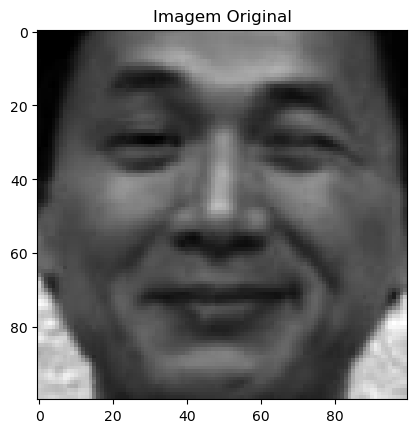

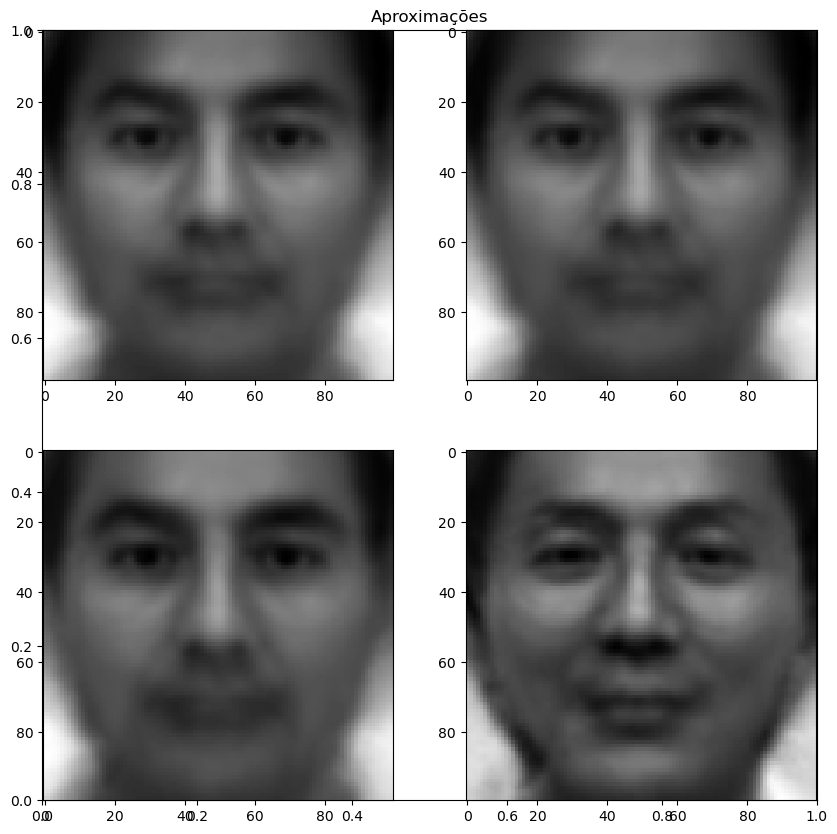

In [26]:
fotos_teste_5 = []
for i in [2,3,4,20]:
    vec_aproximado = mat_media + autovetores[:i,:].T@coef[:i]
    fotos_teste_5.append(vec_aproximado.reshape((100,100)))

    
plt.imshow(mat_teste[:,5].reshape((100,100)).T,cmap='gray')
plt.title('Imagem Original')

plt.figure(figsize=(10, 10))
plt.title('Aproximações')
plt.subplot(221)
plt.imshow(fotos_teste_5[0].T, cmap='gray')
plt.subplot(222)
plt.imshow(fotos_teste_5[1].T, cmap='gray')
plt.subplot(223)
plt.imshow(fotos_teste_5[2].T, cmap='gray')
plt.subplot(224)
plt.imshow(fotos_teste_5[3].T, cmap='gray')


Vamos realizar esse processo para todas as imagens no nosso conjunto de teste.

In [106]:
coef_teste = autovetores[:20,:]@((mat_teste.T - mat_media.T).T)

Como classificar cada uma destas 15 fotos em uma das categorias disponíveis, as categorias sendo os 15 indivíduos? Qual será a taxa de acerto deste sistema de classificação? Vamos primeiro obter arepresentação de cada uma das 150 fotos de treino nos 20 PCAs, exatamente como fizemos com as fotos de teste

In [107]:
coef_treino = autovetores[:20,:]@((mat_pixels.T - mat_media.T).T)

Vamos obter uma representação média de cada um dos 15 indivíduos. Vamos tirar a média dos coeficientes das 10 fotos de cada indivíduo

In [ ]:
coef_medio = []
for i in range(1,16):
    coef_medio.append(np.mean(coef_treino[:,(i-1)*10:i*10],axis=1))
coef_medio = np.asarray(coef_medio).T

(20, 15)

Agora para classificar as faces do conjunto de teste entre os indivíduos devemos olhar para ```coef_teste``` e ver de qual ```coef_medio``` ele mais se aproxima.

In [30]:
idx_proximo = []
for i in range(15):
    idx_proximo.append(np.argmin(np.mean((coef_medio - coef_teste[i])**2,axis=1)))
print(idx_proximo)

[np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9), np.int64(10), np.int64(11), np.int64(12), np.int64(13), np.int64(14)]


## Classificação perfeita!

A lista ```idx_proximo``` indica que a primeira imagem do conjunto de teste erá realcionado ao primeiro indivíduo e assim consecutivamente.

Em conclusão, uma versão aproximada de uma foto em escala de cinza de um rosto humano pode ser obtida como uma combinação linear de umas poucas autofaces (eigenfaces, em inglês): $foto = média geral +c_1v_1+. . . c_kv_k$

Os autovetores ou PCAs $v_1, . . . ,v_k$ da matriz de covariância $\Sigma$ da distribuição conjunta dos pixels formamas autofaces. É impressionante que apenas algumas poucas,  as primeiras $k$, autofaces ou PCAs sejam suficientes para obter uma boa semelhança dos rostos da maioria das pessoas. As autofaces se parecem com um rosto humano médio, sem muitos traços distintivos

O método de autofaces foi proposto por Turk and Pentland (1991a,  1991b). Ele ́e principalmente um método de redução de dimensionalidade, podendo representar muitos indivíduos com um conjunto relativamente pequeno de dados. De fato, no nosso problema, temos uma base de 10 fotos de 15 indivíduos, cada foto armazenada como uma matriz com $10^4$ elementos. Assim, temos, ao todo, $10×15×10^4=O(10^6)bytes$ para armazenar. Vamos imaginar uma base maior com $n$ indivíduos implicando em $O(n10^5)$. Ao chegar uma nova foto precisamos compará-la com as $10n$ fotos por um procedimento ingênuo (naive). Com as autofaces, guardamos apenas 20  pseudo-fotos, as autofaces (possivelmente, apenas 12 seriam suficientes), e os coeficientes médios de cada indivíduo. Veja que o número de autofaces não varia muito com $n$. Mesmo que $n$ seja muito grande, teremos apenas um número pequeno de autofaces. Supondo que sejam 20 autofaces, isto significa guardar $(20×10^4) + (20×n)$.  Por exemplo, com $n= 1000$ e 10 fotos para cada um e com 20 autofaces teríamos que guardar e manipular $2.2×10^5$ enquanto que uma comparação ingênua requer armazenar $10^8$, ou 1000 vezes mais espaço.

No entanto, o método de autofaces pode ter um desempenho muito ruim se existir muita diferença entre as imagens na base de treinamento e as novas imagens (Moon and Phillips, 2001). Uma imagem de um indivíduo sob iluminação frontal pode ter coeficientes muito diferentes do mesmo indivíduo, na mesma pose, sob iluminação lateral intensa. Assim, as novas fotos devem ter representantes similares na base de treino.

Autofaces é uma técnica antiga e já existem muitas variações e melhorias, bem como outra abordagens completamente diferentes para o mesmo problema. Para quem quiser se aprofundar sobre as muitas outras técnicas envolvidas com o reconhecimento de faces, visite o website [http://www.face-rec.org/general-info/](http://www.face-rec.org/general-info/).

# Exercício: Reconhecimento de dígitos #


Este exercício é praticamente a mesma coisa que foi feita acima para as fotos. Ele foi extraído da página web do livro _The Elements of Statistical Learning_, por Hastie, Tibshirani e Friedman. Este excelente (e avançado) livro está disponível para _download_ gratuito e legal na página [http://statweb.stanford.edu/~tibs/ElemStatLearn/](http://statweb.stanford.edu/~tibs/ElemStatLearn/)

O objetivo é construir um algoritmo em Python para a classificação de dígitos escritos á mão. Utilzaremos um conjunto de dados bem famoso. Chamado de _Optical Recognition of Handwritten Digits Data Set
_ disponível em [https://archive.ics.uci.edu/ml/datasets/Optical+Recognition+of+Handwritten+Digits](https://archive.ics.uci.edu/ml/datasets/Optical+Recognition+of+Handwritten+Digits). 

Contudo a biblioteca **sklearn** facilita a aquisição dos dados desse conjunto especificamente.

Shape do dataset: (1797, 64)
Podemos notar que ele já está no formato onde as colunas são pixels linearizados da imagem e cada linha é uma amostra (digito)!


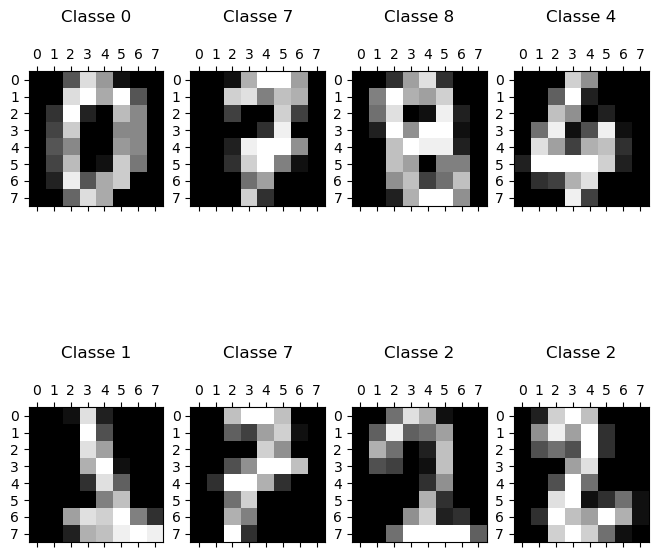

In [34]:
import sklearn
from sklearn import model_selection
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import load_digits

digits = load_digits()
print('Shape do dataset:', digits.data.shape)
print('Podemos notar que ele já está no formato onde as colunas são pixels linearizados da imagem e cada linha é uma amostra (digito)!')

##### Vamos visualizar alguns exemplos ####
indices = [0, 300, 500,  800, 1000, 1200, 1400, 1600] #alguns indices aleatórios
figs, axs = plt.subplots(2, 4, figsize=(8, 8))

i = 0
for ind in indices:
  axs[int(i/4)][i%4].matshow(digits.images[ind], cmap = 'gray')
  axs[int(i/4)][i%4].set_title('Classe %s\n'%(digits.target[ind]))
  i+=1

plt.show()

Você deve agora realizar as seguintes tarefas:
   1. [x] Separar os dados em conjunto de treino e teste (já feito);
   2. [x] Criar uma regra de classificação de novas imagens de dígitos se baseando no exemplo de Eigenfaces
   3. [x] Use os primeiros $k$ autovetores da matriz de covariância entre os pixels para fazer esta regra declassificação. Você deve fazer seus cálculos com $k= 5,10,15,20$.
   4. [x] Usando apenas a amostra de *teste*, crie uma tabela de contingência $10×10$ de confusão $C$.  Nesta matriz $C$ as linhas representam a classe verdadeira do dígito (de 0 a 9) e a coluna a classe em que ele foi alocado. Na entrada $C_{ij}$ você deve colocar o número de itens (ou imagens) que caíram naquela categoria cruzada. Crie a tabela para os quatro valores distintos de $k= 5,10,15,20$. Para isto, você pode usar a função ***plot_confusion_matrix*** disponibilizada neste notebook.
   5. [x] Calcule e imprima a precisão média e o recall médio para cada $k$: A precisão média é a média aritmética da precisão das 10 classes e definida como: $pm=\frac{1}{10}\sum_{i=0}^{9}\frac{C_{ii}}{C_{i+}}$ com $C_{i+}$ sendo a soma da linha $i$ na matriz de confusão. Revocação média é a média aritmética da revocação das 10 classes e definida como: $rm=\frac{1}{10}\sum_{i=0}^{9}\frac{C_{ii}}{C_{i+}}$ com $C_{+i}$ sendo a soma da coluna $i$ na matriz de confusão. Você pode usar a função [sklearn.metrics.confusion_matrix()](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html) para gerar o array da matriz de confusão. Mais detalhes sobre precisão (precision) e revocação (recall) podem ser vistos no verbete Precision and recall na wikipedia. Ver também [http://www.text-analytics101.com/2014/10/computing-precision-and-recall-for.html](http://www.text-analytics101.com/2014/10/computing-precision-and-recall-for.html).

In [35]:
#PARTE 1 - Separando em conjunto de  treino e teste

X = digits.data
y = digits.target
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.1,random_state=1)

#Confirmando que temos todas as classes no conjunto de teste
y_aux = np.argsort(y_test)
y_test = y_test[y_aux]
X_test = X_test[y_aux]
items,counts = np.unique(y_test,return_counts=True)

print('Itens: ', items)
print('Número de vezes em que o item aparece:', counts)


Itens:  [0 1 2 3 4 5 6 7 8 9]
Número de vezes em que o item aparece: [20 19 21 22 18 17 16 21 15 11]


[[2 0 0 0 0 0]
 [1 0 1 0 0 0]
 [0 0 1 1 0 0]
 [0 0 1 2 0 0]
 [0 0 0 0 1 0]
 [0 0 0 0 1 1]]


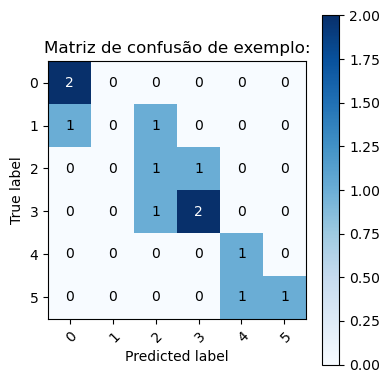

In [36]:
# Funcao para plotar a matriz de confusão - Você pode usá-la para visualizar o desempenho do seu classificador.
# confira um exemplo de uso no final desta célula

from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = np.array(classes)
    classes = classes[unique_labels(y_true, y_pred)]
    

    fig, ax = plt.subplots(figsize = (4,4))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap) 
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')
    
    ax.set_ylim(cm.shape[0] -1 + 0.5, -0.5)
     
    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")

    fig.tight_layout()
    plt.show()
    
############################ Exemplo de como usar a função:############################

y_true = [0,0,3,5,2,1,3,4,5,2,1,3] # Aqui são os valores verdadeiros dos dígitos
y_pred = [0,0,3,4,3,2,3,4,5,2,0,2] # Aqui são os valores preditos pelo seu método (que vão ser gerados por ele, mas neste exemplo estamos colocando na mão)
classes = [0,1,2,3,4,5] # Classes possíveis: nesse exemplo de 0 a 5

#Aqui só obtemos o numpy array da matriz e exibimos (útil para o exercício 5)
cm_array = confusion_matrix(y_true, y_pred)
print(cm_array)

#Aqui plotamos a matriz em um formato bonito :) (útil para o exercício 4)
plot_confusion_matrix(y_true, y_pred, classes, title = "Matriz de confusão de exemplo:")

# Exercícios - By Guima & Smoliski :D

### Passo 1
Centralizamos a matriz de treino $X$ em $\overline{X}$ , e após isso usamos o PCA com base de .9 (arbitrário).

In [ ]:
#Centralizando a matriz para tirar a cov, portanto o PCA
X_mean = np.mean(X_train.T,axis=1)
X_central = (X_train - X_mean)
X_central.shape

(1617, 64)

[]

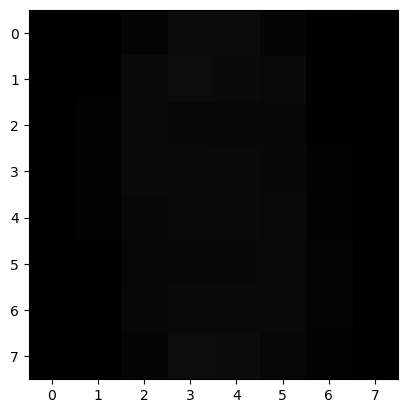

In [ ]:
#Imagem Média -> de difícil vizualização, mas esperado perante os dados
image = Image.fromarray(X_mean.reshape((8,8)))
plt.imshow(image)
plt.plot()

In [46]:
from sklearn.decomposition import PCA

pca = PCA(0.9)

pca.fit(X_central)

print(f'Shape da Matriz de COV com .9:  {pca.components_.shape}\n')
print(f'Auto valores em 21: {pca.explained_variance_ratio_}\n')
print(f'Escala da variância: {np.sum(pca.explained_variance_ratio_)}\n')


Shape da Matriz de COV com .9:  (21, 64)

Auto valores em 21: [0.14918903 0.13661688 0.11740211 0.08395189 0.05818173 0.04932564
 0.04275599 0.03662491 0.03389662 0.03052956 0.02398452 0.02238919
 0.01825177 0.01769524 0.01480953 0.01387509 0.0131469  0.01230839
 0.01021894 0.00922686 0.00892174]

Escala da variância: 0.9033025377911535



## Passo 2
Obtemos os $k$-esimos valores singulares e vetores singulares a direita de $\overline{X}$ e colocamos as amostras da variâncias que serão usandas para o *Exercício 3*

In [191]:
# O futuro no exercício 3
for i in [5,10,15,20]:
    print(f'Com {i} valores')
    print(f'\tAuto valores em {i}: {pca.explained_variance_ratio_[:i]}')
    print(f'\tEscala da variância: {np.sum(pca.explained_variance_ratio_[:i])}\n')

Com 5 valores
	Auto valores em 5: [0.14918903 0.13661688 0.11740211 0.08395189 0.05818173]
	Escala da variância: 0.5453416322796153

Com 10 valores
	Auto valores em 10: [0.14918903 0.13661688 0.11740211 0.08395189 0.05818173 0.04932564
 0.04275599 0.03662491 0.03389662 0.03052956]
	Escala da variância: 0.7384743563434849

Com 15 valores
	Auto valores em 15: [0.14918903 0.13661688 0.11740211 0.08395189 0.05818173 0.04932564
 0.04275599 0.03662491 0.03389662 0.03052956 0.02398452 0.02238919
 0.01825177 0.01769524 0.01480953]
	Escala da variância: 0.835604612883756

Com 20 valores
	Auto valores em 20: [0.14918903 0.13661688 0.11740211 0.08395189 0.05818173 0.04932564
 0.04275599 0.03662491 0.03389662 0.03052956 0.02398452 0.02238919
 0.01825177 0.01769524 0.01480953 0.01387509 0.0131469  0.01230839
 0.01021894 0.00922686]
	Escala da variância: 0.8943807957239298



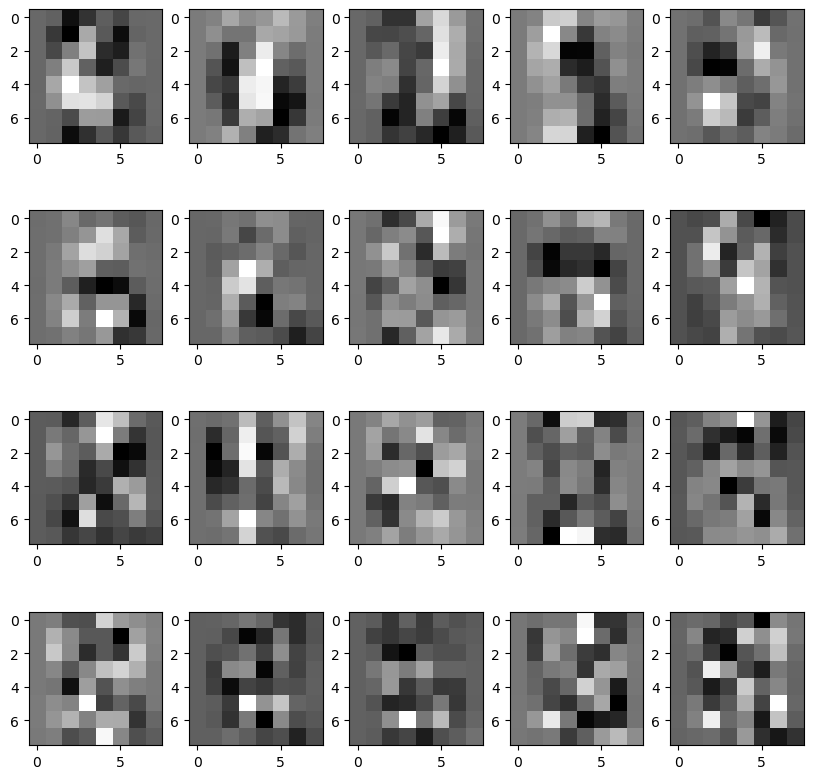

In [84]:
#imagem dos autovetores
auto_digits = []
auto_digits_img = []
for i in range(20):
    auto_digits.append(pca.components_[i])
    auto_digits_img.append(pca.components_[i].reshape((8,8)))

auto_digits = np.asarray(auto_digits)
auto_digits_img = np.asarray(auto_digits_img)
plt.figure(figsize=(10,10))

for i in range(20):
    plt.subplot(4, 5, i+1)
    plt.imshow(auto_digits_img[i],cmap='gray')
    
plt.show()
    

## Passo 3
Ademais, agora nos resta calcular os coeficientes que serão usado para estimar as imagens no treino, utilizando $k=5,10,15,20$. Isso nos dará também o resultado da imagem média de cada classe com a $k$-esima aproximação, tal qual descrito na imagem.

In [111]:
k=5
coef_train_5 = auto_digits[:k, :]@((X_train - X_mean).T)
coef_test_5 = auto_digits[:k,:]@((X_test - X_mean).T)

k=10
coef_train_10 = auto_digits[:k,:]@((X_train - X_mean).T)
coef_test_10= auto_digits[:k,:]@((X_test - X_mean).T)

k=15
coef_train_15 = auto_digits[:k,:]@((X_train - X_mean).T)
coef_test_15 = auto_digits[:k,:]@((X_test - X_mean).T)

k=20
coef_train_20 = auto_digits[:k,:]@((X_train - X_mean).T)
coef_test_20 = auto_digits[:k,:]@((X_test - X_mean).T)

In [112]:
print(coef_train_5)
print(coef_train_5.shape)

[[  3.46201899   6.83584414 -12.08498138 ... -11.40290311   9.75202968
    4.37050639]
 [  9.89338756 -26.18846501   5.59651388 ...  -9.02833096   7.41657372
    4.80059184]
 [ 22.28881615  -9.33008264 -11.1979272  ...   1.71784769  18.96139828
    3.56780089]
 [  6.04233652   3.02387642   0.23548784 ...  -7.18582813 -26.89739624
   13.43506991]
 [  2.53040251   2.35685629   0.95868206 ...  -6.63773002  -1.62757618
  -23.70321749]]
(5, 1617)


In [ ]:
coef_medio_5 = []
coef_medio_10 = []
coef_medio_15 = []
coef_medio_20 = []

for i in items:
    ##Todos os index onde a imagem corresponde ao digito
    index = []
    #while:
    for j in range(X_train.shape[0]):
        if y_train[j] == items[i]:
            index.append(j)

    soma_5 = np.array([0,0,0,0,0])
    soma_10 = np.array([0,0,0,0,0,0,0,0,0,0])
    soma_15 = np.array([0,0,0,0,0,0,0,0,0,0,0,0,0,0,0])
    soma_20 = np.array([0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0])
    index = np.array(index)
    for j in index:
        soma_5 = soma_5 + coef_train_5[:, j].T
        soma_10 = soma_10 + coef_train_10[:, j].T
        soma_15 = soma_15 + coef_train_15[:, j].T
        soma_20 = soma_20 + coef_train_20[:, j].T


    coef_medio_5.append((soma_5 / index.shape[0]).T)
    coef_medio_10.append((soma_10 / index.shape[0]).T)
    coef_medio_15.append((soma_15 / index.shape[0]).T)
    coef_medio_20.append((soma_20 / index.shape[0]).T)



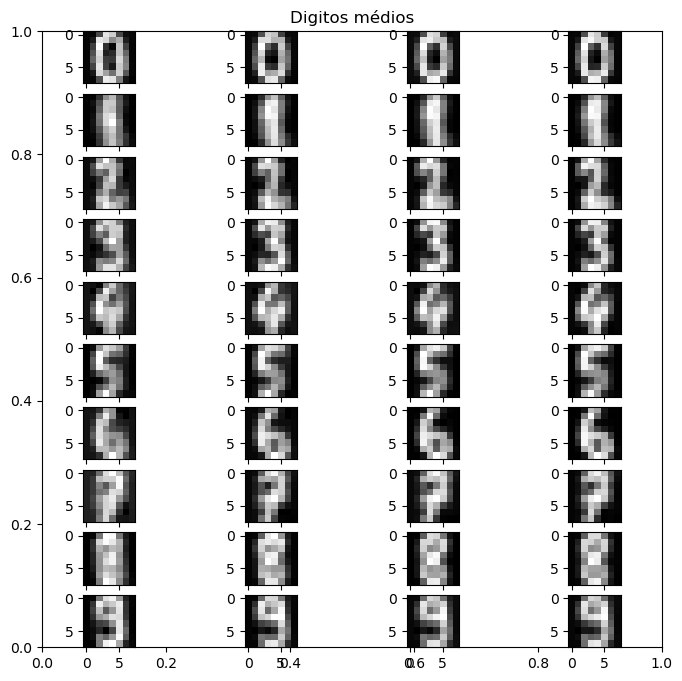

In [161]:
# Imagem média de cada dígito com cada aproximação

plt.figure(figsize=(8,8))
plt.title('Digitos médios')
for i in items:
    vec_aproximado_5 = X_mean + auto_digits[:5,:].T@coef_medio_5[i]
    fotos_teste_5 = vec_aproximado_5.reshape((8,8))

    vec_aproximado_10 = X_mean + auto_digits[:10, :].T@coef_medio_10[i]
    fotos_teste_10 = vec_aproximado_10.reshape((8,8))

    vec_aproximado_15 = X_mean + auto_digits[:15, :].T@coef_medio_15[i]
    fotos_teste_15 = vec_aproximado_15.reshape((8,8))

    vec_aproximado_20 = X_mean + auto_digits[:20, :].T@coef_medio_20[i]
    fotos_teste_20 = vec_aproximado_20.reshape((8,8))

    plt.subplot(10, 4, i*4 + 1)
    plt.imshow(fotos_teste_5, cmap='gray')
    plt.subplot(10, 4, i*4 + 2)
    plt.imshow(fotos_teste_10, cmap='gray')
    plt.subplot(10, 4, i*4 + 3)
    plt.imshow(fotos_teste_15, cmap='gray')
    plt.subplot(10, 4, i*4 + 4)
    plt.imshow(fotos_teste_20, cmap='gray')

plt.show()

## Passo Final
Nesta parte concluimos os Exercícios. A previsão faz parte do 2, a divisão em $k$ a 3, a matriz de confusão termina a 4 e os resultados escritos, a 5. 

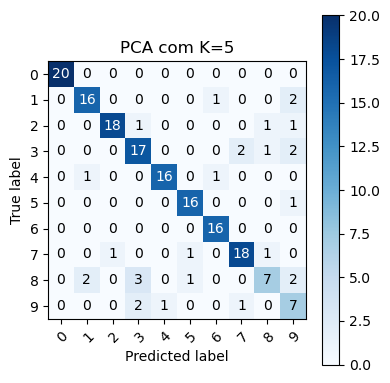

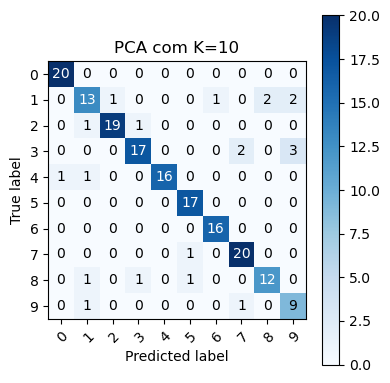

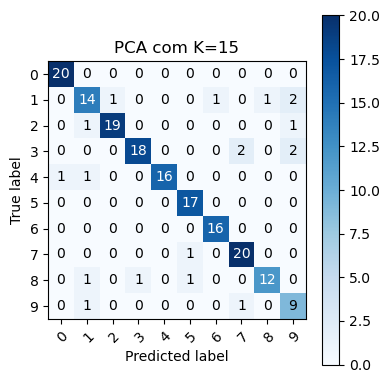

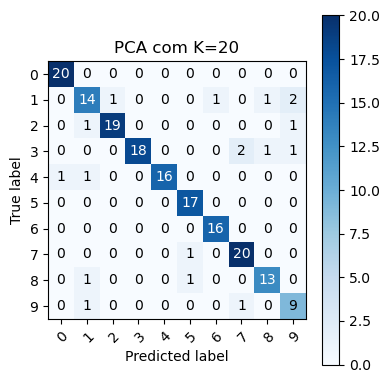

In [179]:
def prevision(coef_medio_, coef_teste_):
    coef_teste_ = coef_teste_.T
    idx = []
    for i in range(coef_teste_.shape[0]):
        idx.append(int(np.argmin(np.mean((coef_medio_ - coef_teste_[i])**2,axis=1))))
        
    return idx

prev_5 = prevision(coef_medio_= coef_medio_5, coef_teste_= coef_test_5)
prev_10 = prevision(coef_medio_= coef_medio_10, coef_teste_= coef_test_10)
prev_15 = prevision(coef_medio_= coef_medio_15, coef_teste_= coef_test_15)
prev_20 = prevision(coef_medio_= coef_medio_20, coef_teste_= coef_test_20)


plot_confusion_matrix(y_test, prev_5, items, title="PCA com K=5")
plot_confusion_matrix(y_test, prev_10, items, title="PCA com K=10")
plot_confusion_matrix(y_test, prev_15, items, title="PCA com K=15")
plot_confusion_matrix(y_test, prev_20, items, title="PCA com K=20")    

In [190]:
cm_5 = confusion_matrix(y_test, prev_5)
cm_10 = confusion_matrix(y_test, prev_10)
cm_15 = confusion_matrix(y_test, prev_15)
cm_20 = confusion_matrix(y_test, prev_20)

cms = [cm_5,cm_10,cm_15,cm_20]
ks = [5,10,15,20]

def mean_precision(cm,classes):
    sum_row = []
    for i in classes:
        sum_row.append((cm[i][i])/np.sum(cm[i]))
    
    return np.mean(np.asarray(sum_row))
       
    

for cm,i in zip(cms,ks):
    print(f'Para K={i}\n\tPrecisão média: {round(mean_precision(cm,items),4)}')  
    print(f'\tRevocação média: {round(mean_precision(cm.T,items),4)}\n')  


Para K=5
	Precisão média: 0.8262
	Revocação média: 0.8271

Para K=10
	Precisão média: 0.8821
	Revocação média: 0.8767

Para K=15
	Precisão média: 0.8919
	Revocação média: 0.8899

Para K=20
	Precisão média: 0.8986
	Revocação média: 0.8945

